### Install and import packages

In [9]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = ["Green", "Blue"]
color_map = mcolors.ListedColormap(["Green", "Blue"])

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

from utils import *

### Set parameters

In [2]:
# Set parameters
# num_data
num_data = 50
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 1000

# data_x marginal distribution parameters
data_x_marginal_params = [
    [[1.0, 5.0], [(1.0, 0.0), (0.0, 1.0)]],
    [[-5.0, 1.0], [(3.0, 0.0), (0.0, 3.0)]]]

# weights prior distribution parameters
weights_prior_params = [[0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]]

# init sigma used in numerical optimization for laplace approximation
laplace_num_iters = 1000


### Generate data_x

$$
\begin{align*}
  \mathrm{data}\_x &= [c_0\_x, c_1\_x]\\
  c_0\_x &\sim p(x|\mu_0, \sigma_0^2) \\
  c_1\_x &\sim p(x|\mu_1, \sigma_1^2)
\end{align*}
$$


In [3]:
# Generate data_x
data_x_marginal_dists = [
    stats.multivariate_normal(mu, sigma, seed=12345) \
        for mu, sigma in data_x_marginal_params]

c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))
c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))
data_x = np.vstack((c0_x, c1_x))
print(data_x.shape)

(50, 2)


### Sample weights, generate sample y from sample weights and visualize data

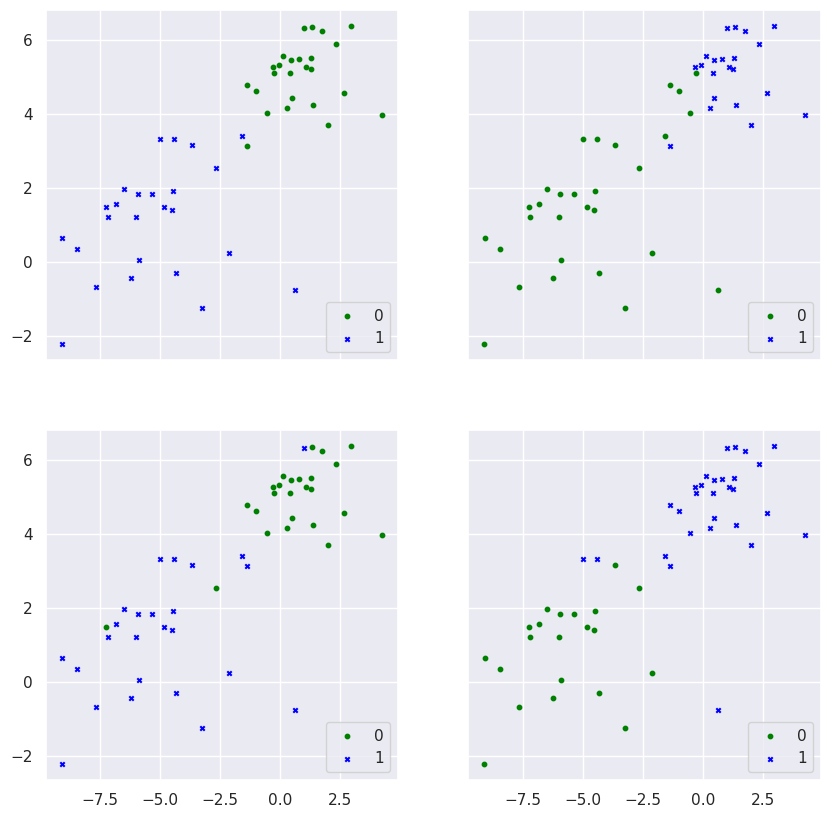

In [4]:
# Sample weights, generate sample data_y, and plot sample data

# plot data_x according to pre-defined classes 
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()
# sns.kdeplot(data_x.squeeze(-1), shade=False, ax=axes[0])
axes[0].scatter(data_x[:num_data_half,0], data_x[:num_data_half,1], color=color_list[0], label=0, s=10, marker="o")
axes[0].scatter(data_x[num_data_half:,0], data_x[num_data_half:,1], color=color_list[1], label=1, s=10, marker="x")
axes[0].legend(loc="lower right")

# sample weights and generate sample y according to the weights, and plot 
weights_prior_dist = stats.multivariate_normal(weights_prior_params[0], weights_prior_params[1])

np.random.seed(0) # reset random generator
for i in range(3):
    # sample weights
    sample_weights_prior = weights_prior_dist.rvs(1)
    
    # generate sample data_y
    sample_logit = 1.0 / (1 + np.exp(-np.dot(data_x, sample_weights_prior)))
    sample_y = stats.bernoulli.rvs(sample_logit)
     
    axes[i+1].scatter(data_x[sample_y==0,0], data_x[sample_y==0,1], 
                      color=color_list[0], label=0, s=10, marker="o")
    axes[i+1].scatter(data_x[sample_y==1,0], data_x[sample_y==1,1], 
                      color=color_list[1], label=1, s=10, marker="x")
    axes[i+1].legend(loc="lower right")

# plt.yticks(np.arange(-1, 1, step=0.25))
plt.show()
    

#### Comments on the plots
1. Even though the data_x is set to be linearly separable, using random prior weights can lead to linearly nonseparable cases.

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [5]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)


samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
for i in range(num_samples):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    # print(sample_a_y.shape)
    # stop
    
    # fit laplace approximation
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = sample_a_y.squeeze(-1),
        X = data_x, 
        wprior = np.array(weights_prior_params[0]), # initialize wprior same as prior params
        H = np.linalg.inv(np.array(weights_prior_params[1])),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = laplace_num_iters
    )
    cov_map = np.linalg.inv(h_map)
    
    # sample weights' posterior
    sample_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map)
    samples_a_weights_posterior.append(sample_a_weights_posterior)    

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(1000, 2)


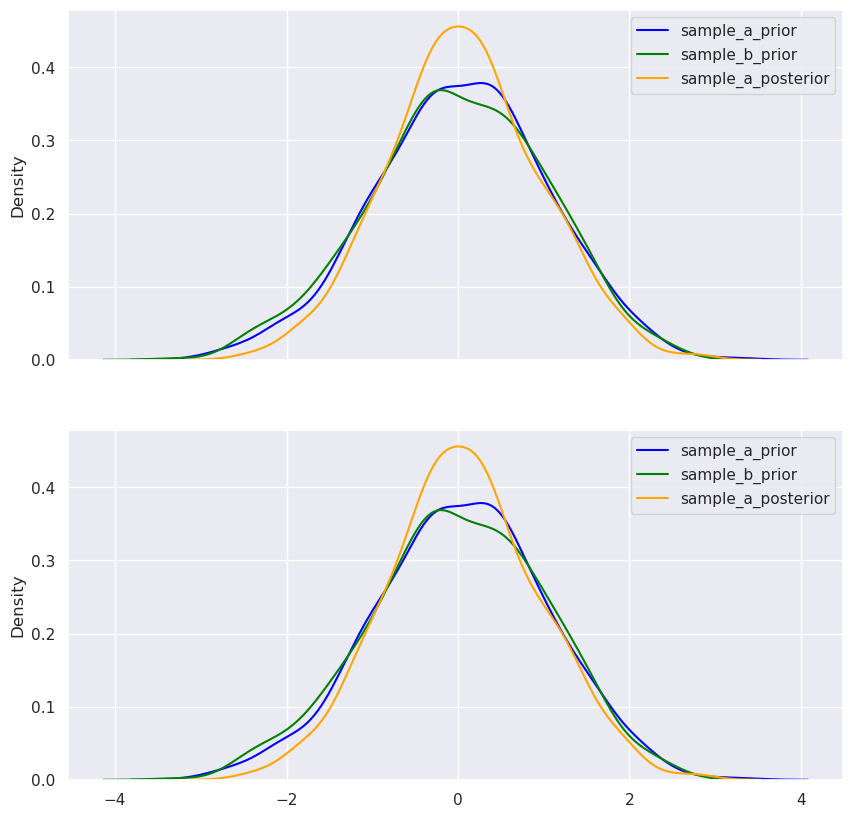

In [6]:
# Visualize the generated prior and posterior samples 
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,0], fill=False, color="blue", label="sample_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,0], fill=False, color="green", label="sample_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,0], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

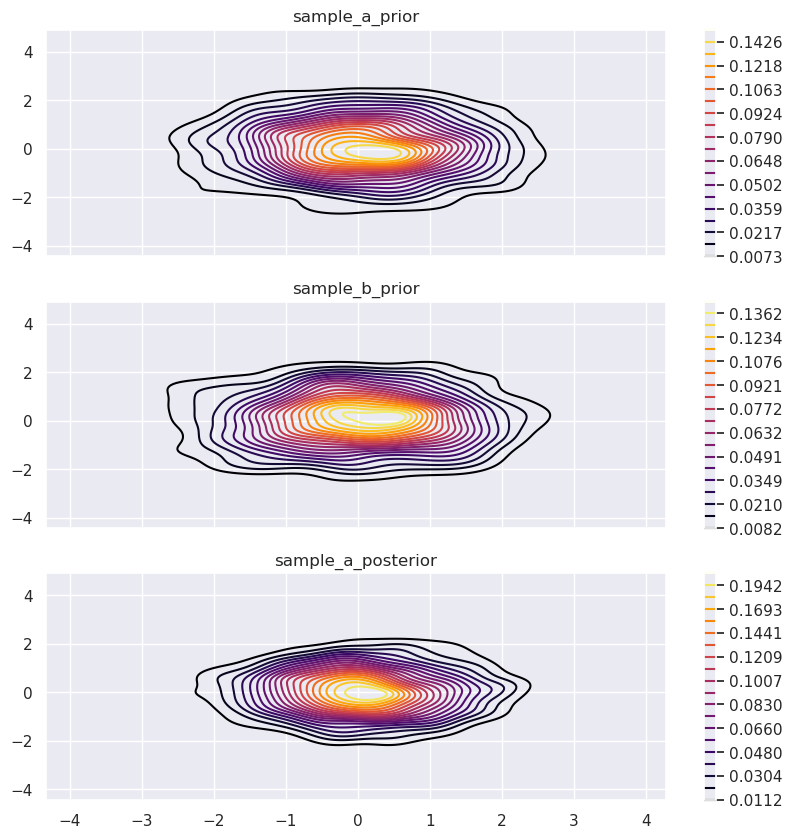

In [7]:
# Visualize the generated prior and posterior samples 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[2])
axes[0].set_title("sample_a_prior")
axes[1].set_title("sample_b_prior")
axes[2].set_title("sample_a_posterior")
plt.show()

### Measure the differences between the prior and samples

* Kernelized two sample test: maximum mean distance with RBF kernel
* Wasserstein distance of two samples
* Difference between the standard deviations (from true mean) of two samples

In [10]:
# Maximum mean distance with RBF kernel
mmd_rbf_prior_a_prior_b = compute_mmd_rbf(samples_a_weights_prior, samples_b_weights_prior)
mmd_rbf_posterior_a_prior_b = compute_mmd_rbf(samples_a_weights_posterior, samples_b_weights_prior)
print(f"MMD between prior a and prior b: {mmd_rbf_prior_a_prior_b:0.5f}")
print(f"MMD between posterior a and prior b: {mmd_rbf_posterior_a_prior_b:0.5f}")

MMD between prior a and prior b: 0.00128
MMD between posterior a and prior b: 0.00857


In [11]:
# Wasserstein distance with RBF kernel
wd_prior_a_prior_b = compute_wasserstein_distance(samples_a_weights_prior, samples_b_weights_prior)
wd_posterior_a_prior_b = compute_wasserstein_distance(samples_a_weights_posterior, samples_b_weights_prior)
print(f"Wasserstein distance between prior a and prior b: {wd_prior_a_prior_b:0.5f}")
print(f"Wasserstein distance between posterior a and prior b: {wd_posterior_a_prior_b:0.5f}")

Wasserstein distance between prior a and prior b: 0.13764
Wasserstein distance between posterior a and prior b: 0.21492


In [12]:
# Difference between the standard deviations (from true mean) of two samples
diff_std_prior_a_prior_b = compute_diff_std(samples_a_weights_prior, samples_b_weights_prior, weights_prior_params[0])
diff_std_posterior_a_prior_b = compute_diff_std(samples_a_weights_posterior, samples_b_weights_prior, weights_prior_params[0])
print(f"Difference standard deviations between between prior a and prior b: {diff_std_prior_a_prior_b:0.5f}")
print(f"Difference standard deviations between posterior a and prior b: {diff_std_posterior_a_prior_b:0.5f}")

Difference standard deviations between between prior a and prior b: 0.00717
Difference standard deviations between posterior a and prior b: 0.20218


In [ ]:
# # measure deviation from true mean, individual features
# for i in range(num_feats):
#     samples_a_prior_avg_distance_i = np.sqrt(np.mean(samples_a_weights_prior[:,i]**2))
#     samples_b_prior_avg_distance_i = np.sqrt(np.mean(samples_b_weights_prior[:,i]**2))
#     samples_a_posterior_avg_distance_i = np.sqrt(np.mean(samples_a_weights_posterior[:,i]**2))
#     print(f"\n-> feature {i}")
#     print(f"samples_a_prior_avg_distance_{i} = {samples_a_prior_avg_distance_i:0.4f}")
#     print(f"samples_b_prior_avg_distance_{i} = {samples_b_prior_avg_distance_i:0.4f}")
#     print(f"samples_a_posterior_avg_distance_{i} = {samples_a_posterior_avg_distance_i:0.4f}")
    
# # measure average distance from true mean, all features
# samples_a_prior_avg_distance_all = np.mean(np.sqrt(np.sum(samples_a_weights_prior**2, axis=1)))
# samples_b_prior_avg_distance_all = np.mean(np.sqrt(np.sum(samples_b_weights_prior**2, axis=1)))
# samples_a_posterior_avg_distance_all = np.mean(np.sqrt(np.sum(samples_a_weights_posterior**2, axis=1)))

# samples_a_prior_avg_distance_all = np.sqrt(np.mean(np.sum(samples_a_weights_prior**2, axis=1)))
# samples_b_prior_avg_distance_all = np.sqrt(np.mean(np.sum(samples_b_weights_prior**2, axis=1)))
# samples_a_posterior_avg_distance_all = np.sqrt(np.mean(np.sum(samples_a_weights_posterior**2, axis=1)))
# print(f"\n-> all features")
# print(f"samples_a_prior_avg_distance_all = {samples_a_prior_avg_distance_all:0.4f}")
# print(f"samples_b_prior_avg_distance_all = {samples_b_prior_avg_distance_all:0.4f}")
# print(f"samples_a_posterior_avg_distance_all = {samples_a_posterior_avg_distance_all:0.4f}")